In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from agent_class import DQN_Agent
from game_class import Game2048_env
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import math
from models import CNN_model
from utils.representations import to_one_hot


# Autoplay trained game

In [14]:
n_games = 1000
n_channels = 12

device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = CNN_model(params_path="params.json", grid_size=4, action_size=4)

model.to(device)

model.load_state_dict(th.load("../data/weights/weights_171.pth"))

agent = DQN_Agent(params_path="params.json", model = model, grid_size=4, action_size=4, epsilon = 0, epsilon_decay=0, epsilon_min=0)

In [19]:
game = Game2048_env(4, n_channels=12)

actions_taken = []
final_scores = []
max_values = []
useless_moves = []
valid_moves = []

for i in range(n_games):
    if i % 100 == 0:
        print(f"Game {i} of {n_games}")
    state = game.reset()
    
    game_over = False
    non_valid_count, valid_count = 0, 0
    max_value = 0
    total_reward = 0
    while not game_over:
        enc_state = to_one_hot(state, n_channels)
        action, _ = agent.choose_action(enc_state, training=False)
        next_state, game_over, reward = game.step(state, action)
        if game_over:
            next_state = None
        if np.array_equal(state, next_state) and not game_over:
            non_valid_count += 1
            k = 0
            while np.array_equal(state, next_state) and k < 10:
                k += 1
                action, _ = agent.choose_action(enc_state, training=False)
                next_state, game_over, reward = game.step(state, action)
            
            if k >= 10:
                action = np.random.randint(0, 4)
                next_state, game_over, reward = game.step(state, action)
        else:
            valid_count += 1
        
        total_reward += reward
                
        
        actions_taken.append(action)
            
        new_max = np.max(next_state)
        if new_max is not None and new_max > max_value:
            max_value = new_max
        
        state = next_state

    final_scores.append(total_reward)
    max_values.append(max_value)
    useless_moves.append(non_valid_count)
    valid_moves.append(valid_count)

Game 0 of 1000
Game 100 of 1000
Game 200 of 1000
Game 300 of 1000
Game 400 of 1000
Game 500 of 1000
Game 600 of 1000
Game 700 of 1000
Game 800 of 1000
Game 900 of 1000


In [20]:
log_max_values = np.log2(max_values)
unique_maxvalues = np.unique(log_max_values)
useless_moves_perc = np.array(useless_moves) / (np.array(useless_moves) + np.array(valid_moves))
actions_taken = np.array(actions_taken)

In [21]:
score_range = [np.min(final_scores), np.max(final_scores)]
log_maxvalue_range = [np.min(log_max_values), np.max(log_max_values)]
useless_moves_range = [np.min(useless_moves_perc), np.max(useless_moves_perc)]

In [22]:
def plot_stats(scores, log_max_values_reached, useless_moves_ratio, game_actions, score_range, log_maxvalue_range, useless_moves_range):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].hist(scores, bins=20, density=True)
    # axs[0, 0].set_xlim(score_range)
    axs[0, 0].set_title("Final Scores")
    axs[0, 0].set_xlabel("Score")
    axs[0, 0].set_ylabel("Frequency")
    
    unique_maxvalues = np.unique(log_max_values_reached)

    axs[0, 1].hist(log_max_values_reached, bins=unique_maxvalues, density=True)
    axs[0, 1].set_title("Log Max Values")
    axs[0, 1].set_xlabel("Log Max Value")
    # axs[0, 1].set_xticks(np.arange(0, log_maxvalue_range[1] + 1, 1))

    axs[1, 0].hist(game_actions, bins=4, align="mid", density=True)
    axs[1, 0].set_title("Actions")
    axs[1, 0].set_xlabel("Action")
    axs[1, 0].set_xticks([0, 1, 2, 3])


    axs[1, 1].hist(useless_moves_ratio, bins=20, density=True)
    axs[1, 1].set_title("Useless Moves")
    axs[1, 1].set_xlabel("Percentage of Useless Moves")
    axs[1, 1].set_ylabel("Frequency")

# Random game

In [24]:
game = Game2048_env(4, n_channels=12)

actions_taken_r = []
final_scores_r = []
max_values_r = []
useless_moves_r = []
valid_moves_r = []



game = Game2048_env(4, n_channels=12)

for i in range(n_games):
    if i % 100 == 0:
        print(f"Game {i} of {n_games}")
    state = game.reset()
    
    game_over = False
    non_valid_count, valid_count = 0, 0
    max_value = 0
    total_reward = 0
    while not game_over:
        enc_state = to_one_hot(state, n_channels)
        action = np.random.randint(0, 4)
        next_state, game_over, reward = game.step(state, action)
        if game_over:
            next_state = None
        if np.array_equal(state, next_state) and not game_over:
            non_valid_count += 1
            k = 0
        else:
            valid_count += 1
        
        total_reward += reward
                
        
        actions_taken_r.append(action)
            
        new_max = np.max(next_state)
        if new_max is not None and new_max > max_value:
            max_value = new_max
        
        state = next_state

    final_scores_r.append(total_reward)
    max_values_r.append(max_value)
    useless_moves_r.append(non_valid_count)
    valid_moves_r.append(valid_count)

Game 0 of 1000
Game 100 of 1000
Game 200 of 1000
Game 300 of 1000
Game 400 of 1000
Game 500 of 1000
Game 600 of 1000
Game 700 of 1000
Game 800 of 1000
Game 900 of 1000


In [26]:
max(final_scores), max(final_scores_r)

(5004, 3368)

In [27]:
log_max_values_r = np.log2(max_values_r)
actions_taken_r = np.array(actions_taken_r).flatten()

useless_moves_perc_r = np.array(useless_moves_r) / (np.array(useless_moves_r) + np.array(valid_moves_r))

In [28]:
min_maxvalues = min(np.min(log_max_values), np.min(log_max_values_r))
max_maxvalues = max(np.max(log_max_values), np.max(log_max_values_r))
log_maxvalue_range = [min_maxvalues, max_maxvalues]

min_score = min(np.min(final_scores), np.min(final_scores_r))
max_score = max(np.max(final_scores), np.max(final_scores_r))
score_range = [min_score, max_score]

min_useless = min(np.min(useless_moves_perc), np.min(useless_moves_perc_r))
max_useless = max(np.max(useless_moves_perc), np.max(useless_moves_perc_r))
useless_moves_range = [min_useless, max_useless]

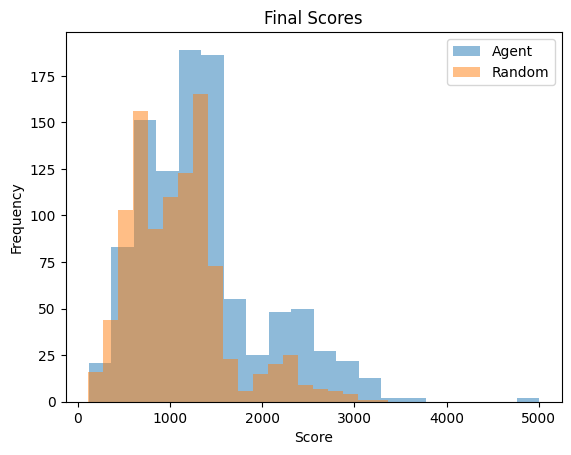

In [62]:
plt.hist(final_scores, bins=20, density=False, alpha=0.5, label="Agent")
plt.hist(final_scores_r, bins=20, density=False, alpha=0.5, label="Random")
plt.legend()
plt.title("Final Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [53]:
average_final_scores = np.mean(final_scores)
average_final_scores_r = np.mean(final_scores_r)

average_difference = average_final_scores - average_final_scores_r
percentage_difference = (average_difference / average_final_scores_r) * 100

average_difference, percentage_difference

(254.74799999999982, 23.221903782624846)

In [46]:
from collections import Counter

max_values_counts = Counter(max_values)
max_values_counts_r = Counter(max_values_r)
print(max_values_counts), print(max_values_counts_r)

Counter({128: 513, 64: 280, 256: 168, 32: 36, 512: 2, 16: 1})
Counter({128: 484, 64: 362, 256: 82, 32: 66, 16: 6})


(None, None)

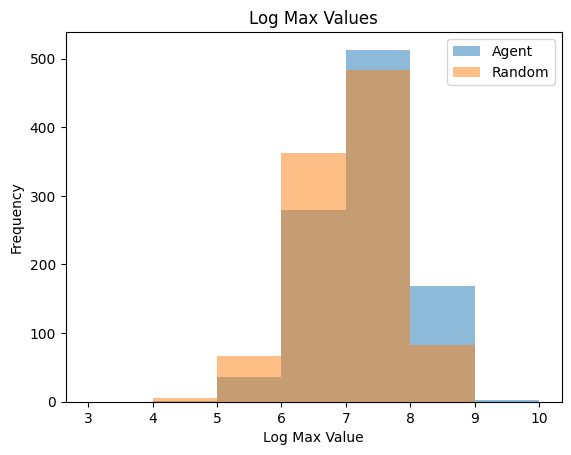

In [57]:
density = False

plt.hist(log_max_values, bins = [3, 4, 5, 6, 7, 8, 9, 10], density=density, alpha=0.5, label="Agent")
plt.hist(log_max_values_r, bins=[3, 4, 5, 6, 7, 8, 9, 10], density=density, alpha=0.5, label="Random")
plt.legend()
plt.title("Log Max Values")
plt.xlabel("Log Max Value")
plt.ylabel("Frequency")
plt.show()

In [54]:
average_useless_moves_perc = np.mean(useless_moves_perc)
average_useless_moves_perc_r = np.mean(useless_moves_perc_r)

average_difference = average_useless_moves_perc - average_useless_moves_perc_r
percentage_difference = (average_difference / average_useless_moves_perc_r) * 100

average_difference, percentage_difference

(-0.09404636640253383, -60.315202948666254)

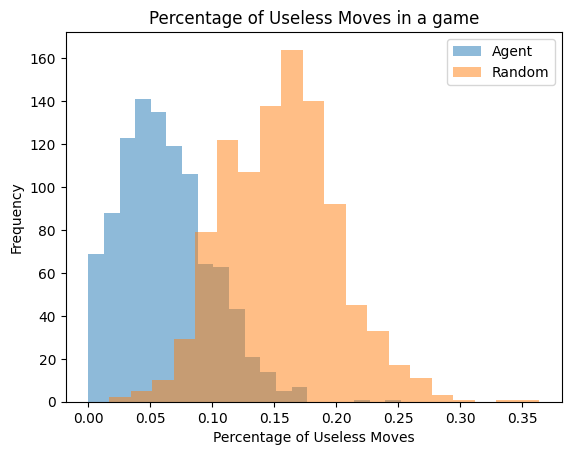

In [58]:
plt.hist(useless_moves_perc, bins=20, density=density, alpha=0.5, label="Agent")
plt.hist(useless_moves_perc_r, bins=20, density=density, alpha=0.5, label="Random")
plt.legend()
plt.title("Percentage of Useless Moves in a game")
plt.xlabel("Percentage of Useless Moves")
plt.ylabel("Frequency")
plt.show()

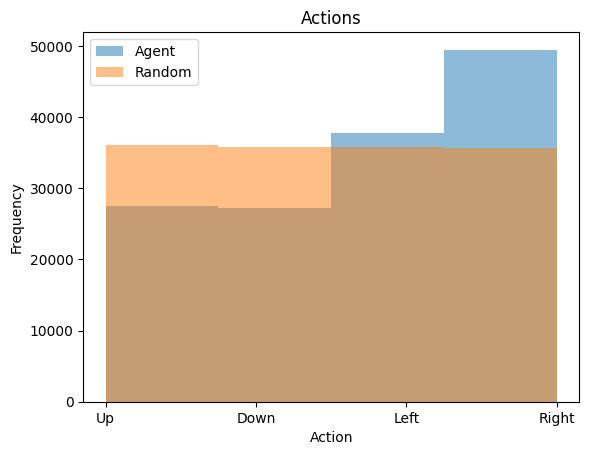

In [59]:
plt.hist(actions_taken, bins=4, align="mid", density=density, alpha=0.5, label="Agent")
plt.hist(actions_taken_r, bins=4, align="mid", density=density, alpha=0.5, label="Random")
plt.legend()
plt.title("Actions")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3])
plt.xticks([0, 1, 2, 3], ['Up', 'Down', 'Left', 'Right'])
plt.show()